This is the notebook for a Weather Classifier.

This is how the classifier will work: 
1. We will start off with Data explortory analysis by visaualising out the data into 11 boxes to see what kind of data we are dealing with. 
2. Next, we will start spliting the data up into training and testing data
3. Train the data 
4. Retry and increase the accuracy of the classifier.  

In [1]:
#Importing in all the needed packages and frameworks
import pandas as pd 
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from torchvision import transforms



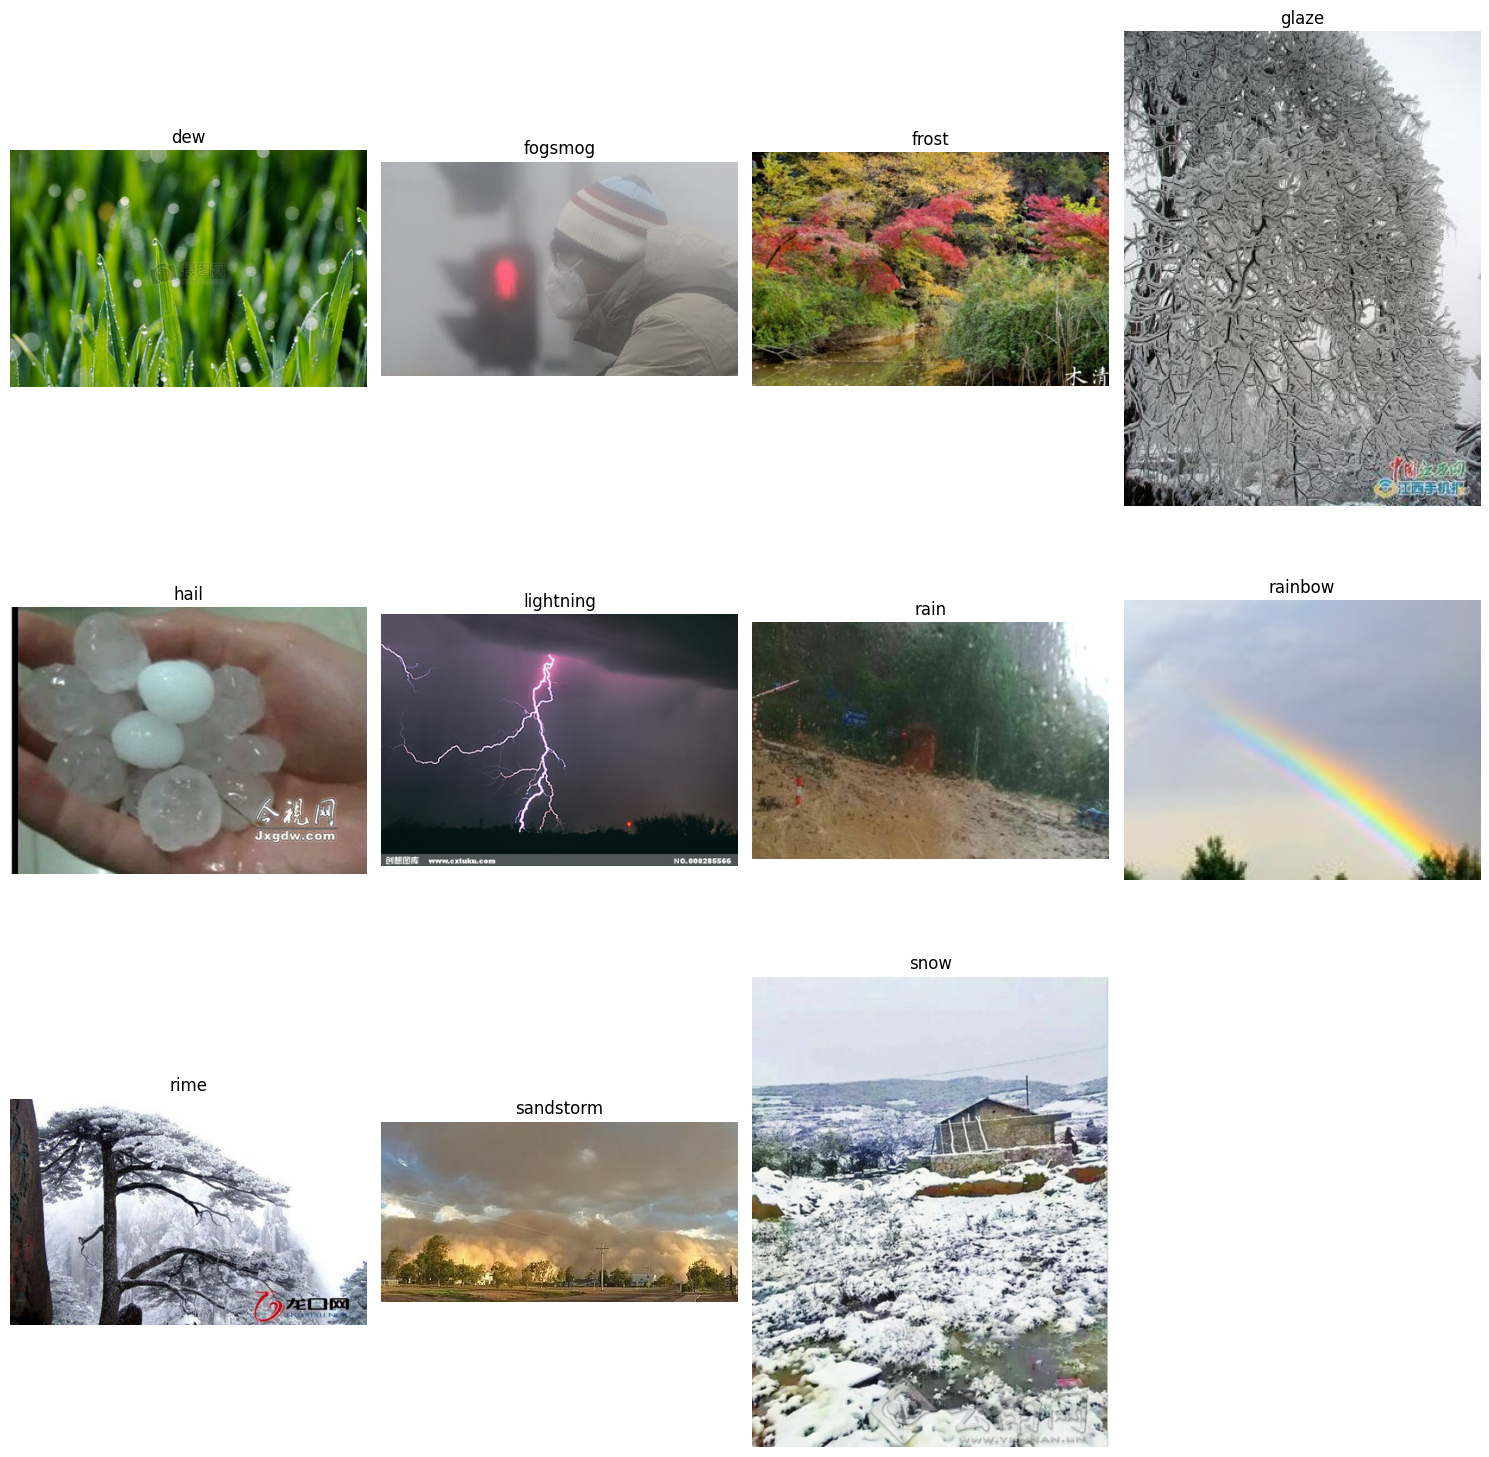

In [2]:
#Visualization of the images 

def plotting_all_images(base_images):
    
    get_dir=[d for d in os.listdir(base_images) if os.path.isdir(os.path.join(base_images,d))]
    
    weather=len(get_dir)
    n_col=int(np.ceil(np.sqrt(weather)))
    n_row=int(np.ceil(weather/n_col))
    
    plt.figure(figsize=(15,15))
    for index,image in enumerate(sorted(get_dir)):
        folder_path=os.path.join(base_images,image)
        try:
            #Get images
            imagefile=[f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
            if imagefile:
                first_image_file=os.path.join(folder_path,imagefile[0])
                open_image=Image.open(first_image_file)
                plt.subplot(n_row,n_col,index+1)
                plt.imshow(open_image)
                plt.title(image)
                plt.axis("off")
                
        except Exception as e:
            print("Error extracting images") 
            
    plt.tight_layout()
    plt.show()
    

plotting_all_images("/Users/jt/Documents/projects/Weather_classifier/dataset")

In [3]:
# split files data 70-15-15 into train,test,validate

def split_data(source_dir,train_dir,test_dir,val_dir,train_percent=0.70,test_percent=0.15,val_percent=0.15):
    
    for dir in [train_dir,test_dir,val_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    for weather_conditions in os.listdir(source_dir):
        source_condition_dir=os.path.join(source_dir,weather_conditions)
        if not os.path.isdir(source_condition_dir):
            continue 
        for i in [train_dir,test_dir,val_dir]:
            condition_dir=os.path.join(i,weather_conditions)
            if not os.path.exists(condition_dir):
                os.makedirs(condition_dir)
            
        all_img=[f for f in os.listdir(source_condition_dir) if f.lower().endswith('jpg')]  
        
        train_image,temp_image=train_test_split(all_img,train_size=train_percent,random_state=33)
        val_image, test_image = train_test_split(temp_image, train_size=val_percent/(val_percent + test_percent),random_state=33)

        
        #Copy Images
        
        for images,dest_dir in [(img, train_dir) for img in train_image] + [(img, val_dir) for img in val_image] + [(img, test_dir) for img in test_image]:
            source_path=os.path.join(source_condition_dir,images)
            dest_path=os.path.join(dest_dir,weather_conditions,images)
            shutil.copy2(source_path,dest_path)
    
base_path = "/Users/jt/Documents/projects/Weather_classifier"
source_path = os.path.join(base_path, "dataset")
train_path = os.path.join(base_path, "data/train")
val_path = os.path.join(base_path, "data/val")
test_path = os.path.join(base_path, "data/test")

split_data(source_path,train_path,val_path,test_path)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# First, our dataset class remains similar because it handles loading images
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load and prepare a single image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

class CustomWeatherClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CustomWeatherClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(train_loader), 100 * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(val_loader), 100 * correct / total

def train_model(train_dir, val_dir, num_epochs=30):
    # Data transformations for training and validation
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets and dataloaders
    train_dataset = WeatherDataset(train_dir, transform=transform_train)
    val_dataset = WeatherDataset(val_dir, transform=transform_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Setup device, model, loss function and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CustomWeatherClassifier(num_classes=len(train_dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                   patience=3, factor=0.1)
    
    # Training history tracking
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                          optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_custom_weather_model.pth')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
    return model, train_dataset.classes

base_path = "/Users/jt/Documents/projects/Weather_classifier/data"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

model, classes = train_model(train_dir, val_dir)